In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10

from google.colab import drive
drive.mount('/content/drive')

from drive.MyDrive.code.imagenets.utils import get_balanced_subset, train_model, test_model, test_model_fgsm

from drive.MyDrive.code.imagenets.convnet import ConvNet
from drive.MyDrive.code.imagenets.fcnet import FCNet
from drive.MyDrive.code.imagenets.weightnet import WeightNet
from drive.MyDrive.code.imagenets.localnet import LocalNet

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Retrieve CIFAR10 dataset.

In [3]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5),
                                                     (0.5, 0.5, 0.5))])

batch_size = 4

trainset = CIFAR10(root='./data', train=True, download=True,
                   transform=transform)

testset = CIFAR10(root='./data', train=False, download=True,
                  transform=transform)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog',
           'horse', 'ship', 'truck']

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Helper functions to train various architectures.

In [3]:
def train_convnet(trainloader, num_epochs):
  channels_list = [3, 6, 16]
  conv_size, pool_size, pool_stride = 5, 2, 2
  fc_dim_list = [16 * 5 * 5, 120, 84, 10]
  conv_net = ConvNet(channels_list, conv_size, pool_size, pool_stride,
                    fc_dim_list)
  
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(conv_net.parameters(), lr=0.001, momentum=0.9)

  train_model(trainloader, conv_net, criterion, optimizer, num_epochs)

  return conv_net

In [4]:
def train_fcnet(trainloader, num_epochs):
  dim_list = [3072, 1176, 400, 120, 84, 10]
  fc_net = FCNet(dim_list)

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(fc_net.parameters(), lr=0.001, momentum=0.9)

  train_model(trainloader, fc_net, criterion, optimizer, num_epochs)

  return fc_net

In [5]:
def train_weightnet(trainloader, num_epochs):
  channels_list = [3, 6, 16]
  conv_size_list = [32, 15]
  padding_list = [(7, 7), (2, 2)]
  fc_dim_list = [16 * 5 * 5, 120, 84, 10]
  weight_net = WeightNet(channels_list, conv_size_list, padding_list,
                         fc_dim_list)

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(weight_net.parameters(), lr=0.001, momentum=0.9)

  train_model(trainloader, weight_net, criterion, optimizer, num_epochs)

  return weight_net

In [6]:
def train_localnet(trainloader, num_epochs):
  channels_list = [3, 6, 16]
  conv_size, conv_stride = 6, 2
  conv_matrix_dim_list = [14, 5]
  fc_dim_list = [16 * 5 * 5, 120, 84, 10]
  local_net = LocalNet(channels_list, conv_size, conv_stride,
                       conv_matrix_dim_list, fc_dim_list)
  
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(local_net.parameters(), lr=0.001, momentum=0.9)

  train_model(trainloader, local_net, criterion, optimizer, num_epochs)
  test_model(testloader, local_net)
  
  return local_net

Train the architectures and save model parameters.

In [8]:
def train_and_save(trainset, examples_per_class, start_iter,
                   end_iter, num_epochs, batch_size):
  for i in range(start_iter, end_iter):
    trainloader = DataLoader(get_balanced_subset(trainset, len(classes),
                                                 examples_per_class),
                             batch_size=batch_size, shuffle=True)
    
    conv_net = train_convnet(trainloader, num_epochs)
    fc_net = train_fcnet(trainloader, num_epochs)
    weight_net = train_weightnet(trainloader, num_epochs)
    local_net = train_localnet(trainloader, num_epochs)

    torch.save(conv_net.state_dict(),
               'drive/MyDrive/code/cifar_results/conv-{}-{}.pth'
               .format(str(examples_per_class), str(i)))
    torch.save(fc_net.state_dict(),
               'drive/MyDrive/code/cifar_results/fc-{}-{}.pth'
               .format(str(examples_per_class), str(i)))
    torch.save(weight_net.state_dict(),
               'drive/MyDrive/code/cifar_results/weight-{}-{}.pth'
               .format(str(examples_per_class), str(i)))
    torch.save(local_net.state_dict(),
               'drive/MyDrive/code/cifar_results/local-{}-{}.pth'
               .format(str(examples_per_class), str(i)))

In [29]:
trial_list = [
  (10, 0, 11, 40, 1),
  (30, 0, 11, 40, 1),
  (100, 0, 8, 20, 2),
  (300, 0, 8, 20, 2),
  (1000, 0, 5, 10, 4),
  (3000, 0, 5, 10, 4),
  (10000, 0, 2, 5, 8),
  (30000, 0, 2, 5, 8),
]

In [10]:
for examples_per_class, start_iter, end_iter, num_epochs, batch_size in trial_list:
  train_and_save(trainset, examples_per_class, start_iter, end_iter, num_epochs,
                 batch_size)

Helper function to load saved models.

In [4]:
def load_convnet(save_path):
  channels_list = [3, 6, 16]
  conv_size, pool_size, pool_stride = 5, 2, 2
  fc_dim_list = [16 * 5 * 5, 120, 84, 10]
  conv_net = ConvNet(channels_list, conv_size, pool_size, pool_stride,
                    fc_dim_list)
  conv_net.load_state_dict(torch.load(save_path))

  return conv_net

In [5]:
def load_fcnet(save_path):
  dim_list = [3072, 1176, 400, 120, 84, 10]
  fc_net = FCNet(dim_list)
  fc_net.load_state_dict(torch.load(save_path))

  return fc_net

In [6]:
def load_weightnet(save_path):
  channels_list = [3, 6, 16]
  conv_size_list = [32, 15]
  padding_list = [(7, 7), (2, 2)]
  fc_dim_list = [16 * 5 * 5, 120, 84, 10]
  weight_net = WeightNet(channels_list, conv_size_list, padding_list,
                         fc_dim_list)
  weight_net.load_state_dict(torch.load(save_path))

  return weight_net

In [7]:
def load_localnet(save_path):
  channels_list = [3, 6, 16]
  conv_size, conv_stride = 6, 2
  conv_matrix_dim_list = [14, 5]
  fc_dim_list = [16 * 5 * 5, 120, 84, 10]
  local_net = LocalNet(channels_list, conv_size, conv_stride,
                       conv_matrix_dim_list, fc_dim_list)
  local_net.load_state_dict(torch.load(save_path))

  return local_net

Analyze model performance.

In [10]:
conv_results_dict = {}
fc_results_dict = {}
weight_results_dict = {}
local_results_dict = {}

for num_examples, _, num_iters, _, _ in trial_list:
  conv_results_dict[num_examples] = []
  fc_results_dict[num_examples] = []
  weight_results_dict[num_examples] = []
  local_results_dict[num_examples] = []

  for i in range(num_iters):
    conv_net = load_convnet('drive/MyDrive/code/cifar_results/conv-{}-{}.pth'.format(num_examples, i))
    fc_net = load_fcnet('drive/MyDrive/code/cifar_results/fc-{}-{}.pth'.format(num_examples, i))
    weight_net = load_weightnet('drive/MyDrive/code/cifar_results/weight-{}-{}.pth'.format(num_examples, i))
    local_net = load_localnet('drive/MyDrive/code/cifar_results/local-{}-{}.pth'.format(num_examples, i))

    conv_results_dict[num_examples].append(test_model(testloader, conv_net)[1])
    fc_results_dict[num_examples].append(test_model(testloader, fc_net)[1])
    weight_results_dict[num_examples].append(test_model(testloader, weight_net)[1])
    local_results_dict[num_examples].append(test_model(testloader, local_net)[1])
  
  print('completed: {} examples'.format(num_examples))

completed: 10 examples
completed: 30 examples
completed: 100 examples
completed: 300 examples
completed: 1000 examples
completed: 3000 examples
completed: 10000 examples
completed: 30000 examples


In [31]:
import pickle

In [12]:
with open('drive/MyDrive/code/cifar_results/conv-dict.pkl', 'wb+') as f:
  pickle.dump(conv_results_dict, f)

with open('drive/MyDrive/code/cifar_results/fc-dict.pkl', 'wb+') as f:
  pickle.dump(fc_results_dict, f)

with open('drive/MyDrive/code/cifar_results/weight-dict.pkl', 'wb+') as f:
  pickle.dump(weight_results_dict, f)

with open('drive/MyDrive/code/cifar_results/local-dict.pkl', 'wb+') as f:
  pickle.dump(local_results_dict, f)

In [32]:
with open('drive/MyDrive/code/cifar_results/conv-dict.pkl', 'rb') as f:
  conv_results_dict = pickle.load(f)

with open('drive/MyDrive/code/cifar_results/fc-dict.pkl', 'rb') as f:
  fc_results_dict = pickle.load(f)

with open('drive/MyDrive/code/cifar_results/weight-dict.pkl', 'rb') as f:
  weight_results_dict = pickle.load(f)

with open('drive/MyDrive/code/cifar_results/local-dict.pkl', 'rb') as f:
  local_results_dict = pickle.load(f)

In [33]:
import matplotlib.pyplot as plt
from statistics import mean

x = []
y_conv = []
y_fc = []
y_weight = []
y_local = []

for num_examples, _, _, _, _ in trial_list:
  x.append(num_examples)
  y_conv.append(mean(conv_results_dict[num_examples])/10000)
  y_fc.append(mean(fc_results_dict[num_examples])/10000)
  y_weight.append(mean(weight_results_dict[num_examples])/10000)
  y_local.append(mean(local_results_dict[num_examples])/10000)

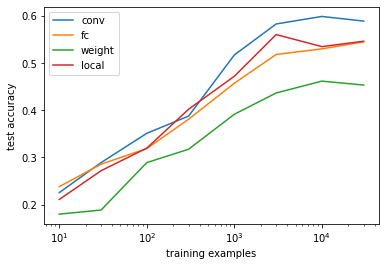

In [40]:
fig, ax = plt.subplots(1, 1)
ax.set_xscale('log')
ax.plot(x, y_conv, label='conv')
ax.plot(x, y_fc, label='fc')
ax.plot(x, y_weight, label='weight')
ax.plot(x, y_local, label='local')
ax.legend()
ax.set_xlabel('training examples')
ax.set_ylabel('test accuracy')
plt.savefig('drive/MyDrive/code/figures/cifar_accuracies.png')
plt.show()

In [8]:
criterion = nn.CrossEntropyLoss()
eps = 0.01

original_inputs_dict = {}
fgsm_conv = {}
fgsm_fc = {}
fgsm_weight = {}
fgsm_local = {}

for num_examples, i in [(1000, 0), (1000, 1), (1000, 2), (1000, 3), (1000, 4),
                        (10000, 0), (10000, 1)]:
  conv_net = load_convnet('drive/MyDrive/code/cifar_results/conv-{}-{}.pth'.format(num_examples, i))
  fc_net = load_fcnet('drive/MyDrive/code/cifar_results/fc-{}-{}.pth'.format(num_examples, i))
  weight_net = load_weightnet('drive/MyDrive/code/cifar_results/weight-{}-{}.pth'.format(num_examples, i))
  local_net = load_localnet('drive/MyDrive/code/cifar_results/local-{}-{}.pth'.format(num_examples, i))

  _, correct_conv = test_model(testloader, conv_net)
  _, fgsm_correct_conv, original_inputs, fgsm_inputs_conv = test_model_fgsm(testloader, conv_net, criterion, eps)

  _, correct_fc = test_model(testloader, fc_net)
  _, fgsm_correct_fc, original_inputs, fgsm_inputs_fc = test_model_fgsm(testloader, fc_net, criterion, eps)

  _, correct_weight = test_model(testloader, weight_net)
  _, fgsm_correct_weight, original_inputs, fgsm_inputs_weight = test_model_fgsm(testloader, weight_net, criterion, eps)

  _, correct_local = test_model(testloader, local_net)
  _, fgsm_correct_local, original_inputs, fgsm_inputs_local = test_model_fgsm(testloader, local_net, criterion, eps)

  original_inputs_dict[(num_examples, i)] = original_inputs
  fgsm_conv[(num_examples, i)] = {'correct': correct_conv, 'fgsm_correct': fgsm_correct_conv, 'fgsm_inputs': fgsm_inputs_conv}
  fgsm_fc[(num_examples, i)] = {'correct': correct_fc, 'fgsm_correct': fgsm_correct_fc, 'fgsm_inputs': fgsm_inputs_fc}
  fgsm_weight[(num_examples, i)] = {'correct': correct_weight, 'fgsm_correct': fgsm_correct_weight, 'fgsm_inputs': fgsm_inputs_weight}
  fgsm_local[(num_examples, i)] = {'correct': correct_local, 'fgsm_correct': fgsm_correct_local, 'fgsm_inputs': fgsm_inputs_local}

  print('finished {}, {}'.format(str(num_examples), str(i)))

finished 1000, 0
finished 1000, 1
finished 1000, 2
finished 1000, 3
finished 1000, 4
finished 10000, 0
finished 10000, 1


In [9]:
from statistics import mean

correct_dict = {k: [] for k in ['conv', 'fc', 'weight', 'local']}
fgsm_correct_dict = {k: [] for k in ['conv', 'fc', 'weight', 'local']}

for i in range(5):
  correct_dict['conv'].append(fgsm_conv[(1000, i)]['correct'])
  fgsm_correct_dict['conv'].append(fgsm_conv[(1000, i)]['fgsm_correct'])

  correct_dict['fc'].append(fgsm_fc[(1000, i)]['correct'])
  fgsm_correct_dict['fc'].append(fgsm_fc[(1000, i)]['fgsm_correct'])

  correct_dict['weight'].append(fgsm_weight[(1000, i)]['correct'])
  fgsm_correct_dict['weight'].append(fgsm_weight[(1000, i)]['fgsm_correct'])

  correct_dict['local'].append(fgsm_local[(1000, i)]['correct'])
  fgsm_correct_dict['local'].append(fgsm_local[(1000, i)]['fgsm_correct'])

correct_data = {k: mean(v) for k, v in correct_dict.items()}
fgsm_correct_data = {k: mean(v) for k, v in fgsm_correct_dict.items()}

In [10]:
correct_data, fgsm_correct_data

({'conv': 5169.2, 'fc': 4571.4, 'local': 4718.6, 'weight': 3914.4},
 {'conv': 3374.8, 'fc': 3209.4, 'local': 2829.4, 'weight': 2989})

In [11]:
correct_dict = {k: [] for k in ['conv', 'fc', 'weight', 'local']}
fgsm_correct_dict = {k: [] for k in ['conv', 'fc', 'weight', 'local']}

for i in range(2):
  correct_dict['conv'].append(fgsm_conv[(10000, i)]['correct'])
  fgsm_correct_dict['conv'].append(fgsm_conv[(10000, i)]['fgsm_correct'])

  correct_dict['fc'].append(fgsm_fc[(10000, i)]['correct'])
  fgsm_correct_dict['fc'].append(fgsm_fc[(10000, i)]['fgsm_correct'])

  correct_dict['weight'].append(fgsm_weight[(10000, i)]['correct'])
  fgsm_correct_dict['weight'].append(fgsm_weight[(10000, i)]['fgsm_correct'])

  correct_dict['local'].append(fgsm_local[(10000, i)]['correct'])
  fgsm_correct_dict['local'].append(fgsm_local[(10000, i)]['fgsm_correct'])

correct_data = {k: mean(v) for k, v in correct_dict.items()}
fgsm_correct_data = {k: mean(v) for k, v in fgsm_correct_dict.items()}

In [12]:
correct_data, fgsm_correct_data

({'conv': 5984, 'fc': 5298, 'local': 5345.5, 'weight': 4615.5},
 {'conv': 4110, 'fc': 3977, 'local': 3241, 'weight': 3468.5})

In [36]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid

def imshow(img, save_path):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.savefig(save_path)
    plt.show()

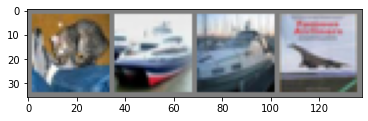

In [41]:
imshow(make_grid(original_inputs_dict[(10000, 0)]), 'drive/MyDrive/code/figures/cifar_original_inputs.png')

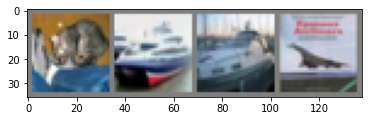

In [42]:
imshow(make_grid(fgsm_weight[(10000, 0)]['fgsm_inputs']), 'drive/MyDrive/code/figures/cifar_weight_fgsm_inputs.png')

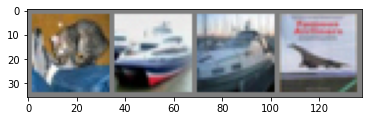

In [43]:
imshow(make_grid(fgsm_local[(10000, 0)]['fgsm_inputs']), 'drive/MyDrive/code/figures/cifar_local_fgsm_inputs.png')

Old code.

In [ ]:
trainloader = DataLoader(get_balanced_subset(trainset, len(classes), 1000),
                         batch_size=batch_size, shuffle=True)
num_epochs = 5

In [ ]:
channels_list = [3, 6, 16]
conv_size, pool_size, pool_stride = 5, 2, 2
fc_dim_list = [16 * 5 * 5, 120, 84, 10]
conv_net = ConvNet(channels_list, conv_size, pool_size, pool_stride,
                   fc_dim_list)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(conv_net.parameters(), lr=0.001, momentum=0.9)

train_model(trainloader, conv_net, criterion, optimizer, num_epochs)
test_model(testloader, conv_net)

In [ ]:
dim_list = [3072, 1176, 400, 120, 84, 10]
fc_net = FCNet(dim_list)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(fc_net.parameters(), lr=0.001, momentum=0.9)

train_model(trainloader, fc_net, criterion, optimizer, num_epochs)
test_model(testloader, fc_net)

In [ ]:
channels_list = [3, 6, 16]
conv_size_list = [32, 15]
padding_list = [(7, 7), (2, 2)]
fc_dim_list = [16 * 5 * 5, 120, 84, 10]
weight_net = WeightNet(channels_list, conv_size_list, padding_list, fc_dim_list)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(weight_net.parameters(), lr=0.001, momentum=0.9)

train_model(trainloader, weight_net, criterion, optimizer, num_epochs)
test_model(testloader, weight_net)

In [ ]:
channels_list = [3, 6, 16]
conv_size, conv_stride = 6, 2
conv_matrix_dim_list = [14, 5]
fc_dim_list = [16 * 5 * 5, 120, 84, 10]
local_net = LocalNet(channels_list, conv_size, conv_stride,
                     conv_matrix_dim_list, fc_dim_list)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(local_net.parameters(), lr=0.001, momentum=0.9)

train_model(trainloader, local_net, criterion, optimizer, num_epochs)
test_model(testloader, local_net)